# Simulation of model

In [2]:
import numpy as np
import pandas as pd
from sympy import symbols, solve, Eq
from scipy.optimize import fmin, fsolve, minimize
from scipy import integrate
#import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#import fitter
import scipy.stats
import tools # this imports the file tools.py // must be in the same folder as the current file

## Setup
draw n random values for sigma

define $\pi$, $\phi$ and $\alpha$

count    50000.000000
mean       840.091261
std        449.056322
min        110.440961
25%        528.055082
50%        740.822711
75%       1038.067955
max       5989.024344
dtype: float64


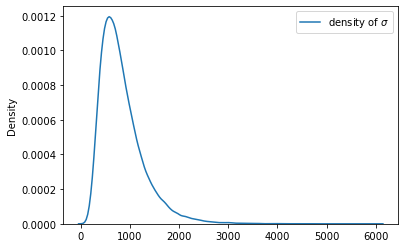

In [3]:
# number of random sigmas
np.random.seed(123)
n_rand = 50000
# mean and sd of normal distribution 
m, s = 2,0.5
sigma = np.random.lognormal(mean=m, sigma=s, size=n_rand) # takes values for normal distribution as inputs
# make to list
sigma = sigma.tolist()
sigma = [x * 100 for x in sigma] # rescaling sigma
print(pd.Series(sigma).describe())
# distribution
sns.kdeplot(sigma, label=r'density of $\sigma$')
plt.legend()


pi = 250
phi = 50
phi120 = 100
alpha = 0.8


## Fine Schedule

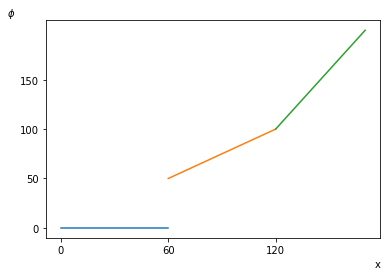

In [3]:
x0, y0 = [0,60], [0,0]
x1, y1 = [60, 120], [50,100]
x2, y2 = [120,170], [100,200]
plt.plot(x0, y0)
plt.plot(x1,y1,x2, y2)
plt.xticks([0,60,120])
plt.yticks([0,50,100,150])
plt.xlabel('x', loc = 'right')
plt.ylabel(r'$\phi$', loc = 'top', rotation = 'horizontal')
plt.show()

## Cost functions
fixing cost function $C(x,\sigma) = \frac{\sigma}{\alpha} (\frac{x}{\sigma})^{-\alpha}$

Text(0, 0.5, 'C(x)')

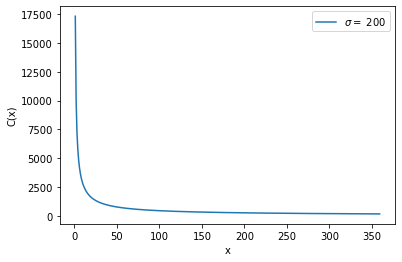

In [4]:
# plot for fixed sigma
sigma_fix = 200
x = np.arange(1,360,1)  
plt.plot(x,tools.C(x,sigma_fix, alpha), label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x)')

Cost function $K(x,\sigma) = (\pi + \phi)x + C(x, \sigma)$ with x, $\sigma$, $\pi$ and $\phi$ as inputs, $\phi = 50$ Rs if $x > 60$

Text(0, 0.5, 'K(x)')

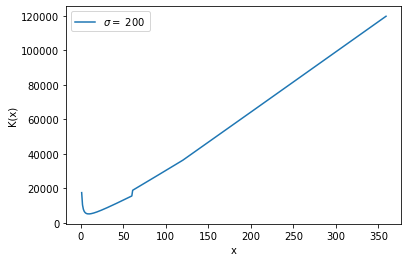

In [5]:
# plot K with fixed sigma 
x = np.arange(1,360,1)
Ks = [tools.K(x,sigma = sigma_fix, pi = pi, phi = phi, phi120 = phi120, alpha = alpha) for x in x]  
plt.plot(x,Ks, label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('K(x)')  

optimal x as a function of $\sigma$ : $x = \sigma (\pi + \phi)^{-1/(1+\alpha)}$

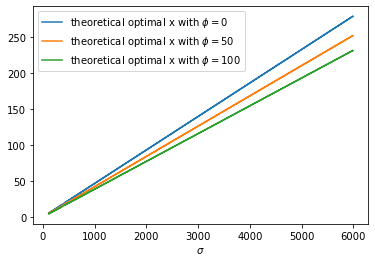

In [6]:
# optimal theoretical x
def xopt(sigma, pi=pi, phi=phi, alpha = alpha):
    x = sigma * (pi + phi)**(-1/(1+alpha))
    return x

xopts = [xopt(s, phi=0) for s in sigma]

# optimal theoretical x with phi
xopts2 = [xopt(s, phi=phi) for s in sigma]

xopts3 = [xopt(s, phi=phi120) for s in sigma]

#print('xopts:',pd.Series(xopts).describe())
#print('xopts2:',pd.Series(xopts2).describe())

plt.plot(sigma, xopts, label =r'theoretical optimal x with $\phi = 0$')
plt.plot(sigma, xopts2, label =f'theoretical optimal x with $\phi = {phi}$')
plt.plot(sigma, xopts3, label =f'theoretical optimal x with $\phi = {phi120}$')

plt.xlabel(r'$\sigma$')
plt.legend()


### Fine schedule tradeoff


At $x=60$: 

$\pi*60 + \frac{\sigma}{\alpha} (\frac{60}{\sigma})^{-\alpha} \leq (\pi + \phi)^{\alpha/(1+\alpha)} (\sigma + \frac{\sigma}{\alpha})$


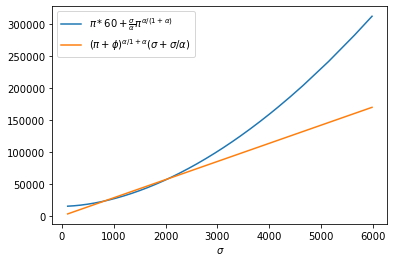

In [7]:
left = [tools.K(60,s,pi,phi, phi120,alpha)  for s in sigma]
right = [(s + s/alpha)*(pi + phi)**(alpha/(1+alpha))  for s in sigma]
tradeoff = pd.DataFrame({'sigma':sigma, 'left':left, 'right':right}).sort_values('sigma')

plt.plot(tradeoff.sigma, tradeoff.left, label = r'$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)}$')
plt.plot(tradeoff.sigma, tradeoff.right, label = r'$(\pi + \phi)^{\alpha/1+\alpha} ( \sigma + \sigma / \alpha) $')
plt.xlabel(r'$\sigma$')
plt.legend()

At $x=120$:

$K(120,s,\pi) \leq (\pi + \phi)*120 + (\pi + \phi_{120})*(x^* - 120) + C(x^*)$


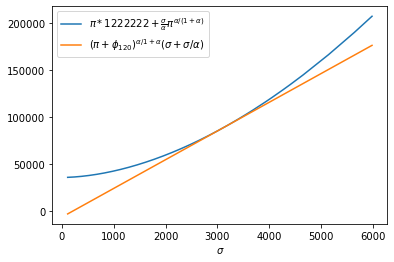

In [8]:
left2 = [tools.K(120,s,pi,phi, phi120,alpha)  for s in sigma]
right2 = [(pi+phi)*120 + (pi+phi120)*(s * (pi + phi120)**(-1/(1+alpha)) - 120) + (s/alpha)*(s * (pi + phi120)**(-1/(1+alpha))/s)**(-alpha)  for s in sigma]
tradeoff2 = pd.DataFrame({'sigma':sigma, 'left2':left2, 'right2':right2}).sort_values('sigma')

plt.plot(tradeoff2.sigma, tradeoff2.left2, label = r'$\pi*1222222 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)}$')
plt.plot(tradeoff2.sigma, tradeoff2.right2, label = r'$(\pi + \phi_{120})^{\alpha/1+\alpha} ( \sigma + \sigma / \alpha) $')
plt.xlabel(r'$\sigma$')
plt.legend()
#plt.xlim(3000,3500)
#plt.ylim(85000,100000)

solve for $\sigma$ where equality holds

In [9]:
## there are two solutions, take higher one (need to think a bit more about this)
s = symbols('s')
exp = tools.K(60,s,pi,phi,phi120,alpha) - (pi + phi)**(alpha/(1+alpha)) * (s + s/alpha)
sigma_bar = solve(exp)
if len(sigma_bar) > 0:
    print('Cutoff sigma is', f'{sigma_bar[1]:.2f}')
else: print('lines do not intersect')

def exp(s):
    return tools.K(120,s,pi,phi,phi120,alpha) - ((pi+phi)*120 + (pi+phi120)*(s * (pi + phi120)**(-1/(1+alpha)) - 120) + (s/alpha)*(s * (pi + phi120)**(-1/(1+alpha))/s)**(-alpha))
sigma_bar = sigma_bar[1]

sigma_bar120 = fsolve(exp,1000)
if len(sigma_bar120) == 1:
    print('Cutoff sigma is', f'{sigma_bar120[0]:.2f}')
    sigma_bar120 = sigma_bar120[0]
elif len(sigma_bar120) == 2:
    print('Cutoff sigma is', f'{sigma_bar120[1]:.2f}')
    sigma_bar120 = sigma_bar120[1]
else: print('lines do not intersect')

Cutoff sigma is 2048.74
Cutoff sigma is 3108.51


therotical x combining both.. Let's call this D
here we should use the equation solving for sigma bar (at the very bottom) which will give us a sigma below which we take xopt and above which we take xopts2. create a variable s.t. x = xopts if $\sigma<\bar{\sigma}$ and $x = xopts2$ otherwise. 

solve for $\sigma$ where x = 60 and x = 120

In [10]:
s = symbols('s')
exp = xopt(s, pi=pi, phi=0, alpha = alpha) - 60
sigma_sixty = solve(exp)
if len(sigma_sixty) > 0:
    print('sigma of duration 60 is', f'{sigma_sixty[0]:.2f}')
else: print('lines do not intersect')

exp = xopt(s, pi=pi, phi=phi, alpha = alpha) - 120
sigma_120 = solve(exp)
if len(sigma_120) > 0:
    print('sigma of duration 120 is', f'{sigma_120[0]:.2f}')
else: print('lines do not intersect')

sigma_sixty = sigma_sixty[0]
sigma_120 = sigma_120[0]

sigma of duration 60 is 1289.26
sigma of duration 120 is 2853.38


In [11]:
s = symbols('s')
exp = xopt(sigma_bar, pi=pi, phi=0, alpha = alpha) - s - 60
res = solve(exp) 

exp = xopt(sigma_bar120, pi=pi, phi=phi, alpha = alpha) - s - 120
res120 = solve(exp) 

deltaX = res[0]
deltaX120 = res120[0]
print(deltaX,deltaX120)

35.3448064033245 10.7295905075578


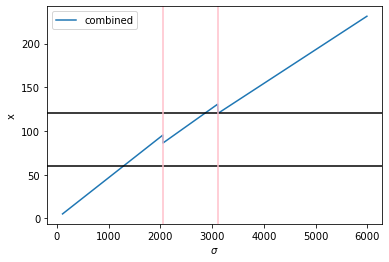

In [12]:
combined = [xopt(s, phi=0) if s <= sigma_bar else xopt(s, phi=phi) if s <= sigma_bar120 else xopt(s, phi=phi120) for s in sigma]
combined_sorted = [xopt(s, phi=0) if s <= sigma_bar else (xopt(s, phi=phi) if s <= sigma_bar120 else xopt(s, phi=phi120)) for s in sorted(sigma)]

plt.plot(sorted(sigma), combined_sorted, label = 'combined')
plt.axhline(60, color ='black')
plt.axhline(120, color ='black')
plt.axvline(sigma_bar, color ='pink')
plt.axvline(sigma_bar120, color ='pink')
plt.ylabel('x')
plt.xlabel(r'$\sigma$')
plt.legend()

This is not entirely correct because it doesnt include bunching. To include bunching: recall that a firm will bunch (meaning choose x = 60) if the cost of not bunching at xopts2 (paying phi) is higher than the cost of bunching (choosing x=60 and not paying phi). This will be a range between sigma at xopts=60.
Step 1: solve for sigma from xopts = 60 (phi = 0)

Step 2: solve for sigma indifference as above

Step 3: replace x = 60 for all sigma between the two sigmas

Step 4: replace x = xopts for the sigmas below sigma in step 1, and x = xopts2 for the sigmas above sigma indifference in step 2. 

Let's do this and plot D against the x's we're getting from the minimizations.

1289.25891776314 2048.73569863144
2853.38070987422 3108.5107647001714


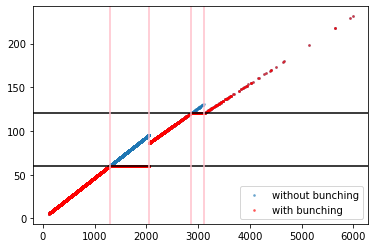

In [13]:
dfx = pd.DataFrame(list(zip(sigma, xopts, xopts2, xopts3, combined)), columns=['sigma', 'xopts', 'xopts2', 'xopts3', 'combined'])

# step 1: sigma at 60 and 120
# step 2: sigma_bar
print(sigma_sixty, sigma_bar)
print(sigma_120, sigma_bar120)

# step 3
dfx['combined'] = dfx.apply(lambda row: 60 if (row.sigma <= sigma_bar and row.sigma > sigma_sixty) else row.combined, axis = 1)
dfx['combined'] = dfx.apply(lambda row: 120 if (row.sigma <= sigma_bar120 and row.sigma > sigma_120) else row.combined, axis = 1)

# step 4
dfx['combined'] = dfx.apply(lambda row: row.xopts if row.sigma < sigma_sixty else (row.xopts2 if row.sigma > sigma_bar and row.sigma <= sigma_sixty else row.combined), axis = 1)
dfx['combined'] = dfx.apply(lambda row: row.xopts3 if row.sigma > sigma_bar120 else row.combined, axis = 1)

plt.scatter(sigma, combined, marker = 'o', label='without bunching', alpha=.5, s = 3)
plt.scatter(dfx.sigma, dfx.combined, marker = 'o', label='with bunching', alpha=.5, s= 3, color='red')
plt.axhline(60, color ='black')
plt.axhline(120, color ='black')
plt.axvline(sigma_bar, color ='pink')
plt.axvline(sigma_sixty, color ='pink')
plt.axvline(sigma_bar120, color ='pink')
plt.axvline(sigma_120, color ='pink')
plt.legend()

### Minimization
find the minimum x of K() for all sigmas

In [14]:
'''
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    x = fmin(K,x0 = 10, args=(s,pi, phi, alpha), disp=False) 
    #else: x[0] = np.nan    
    if x < 0:
        raise ValueError('x negative')
    xstar[s] = x[0] # output of fmin is a list, access first element

'''
xstar = {}
for s in sigma:
    x = minimize(tools.K, x0 = 8, args=(s,pi, phi, phi120, alpha), method = 'powell', # Nelder-Mead
                 tol = 1e-8, options={'disp': False}) 
    xstar[s] = x['x'] # output of minimize is a list 

### put in dataframe

df = pd.DataFrame.from_dict(xstar, orient='index', columns=['xstar'])
df = df.reset_index()
df = df.rename(columns={'index':'sigma'})


# calculate fixing cost C
df['fixing_cost'] = df.apply(lambda row: tools.C(row.sigma,row.xstar, alpha=alpha), axis=1)
# calculate cost K
df['K'] = df.apply(lambda row: tools.K(row.xstar, row.sigma, pi = pi, phi = phi, phi120 = phi120, alpha=alpha), axis=1)
# cost K if bunching
df['KBunch'] = df.apply(lambda row: tools.K(60, row.sigma, pi = pi, phi = phi, phi120 = phi120, alpha=alpha), axis=1)


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:16: RuntimeWarning: invalid value encountered in power
  return  first * (second**power)


In [15]:
pd.set_option('display.max_rows', df.shape[0]+1)
#df.sort_values('sigma')
#print(df)

So it seems that the algorithm is not always picking the right solutions. To be more precise it doesn't always pick the corner solution at 60 when it should (compare the densities and the binned graphs of the two xs below). 

What i did is compare the K at the optimal solution picked by the algorithm to K at bunching to check if it's choosing the correct solution (basically for sigma < sigma bar=2048). Have a look at KBunch vs K around the value of sigma bar to see what I mean.

The algorithm seems to be sensitive to the initial values. Somehow x=10 gave me the (almost) correct solutions. 

Can we try to improve on this or at least understand why? Ultimately we actually don't need the minimization there, we can do it ourselves (i.e. just keep x theoritcal) but we should understand why this is happening.

## Plots
compare the theoretical x and the x calculated from minimization and their density

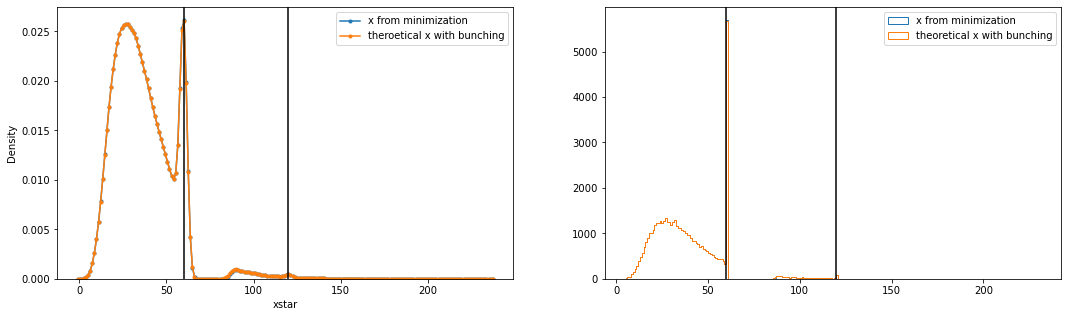

In [16]:
fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(df.xstar, marker='o', markersize=3, label = f'x from minimization', ax=axs[0]) 
sns.kdeplot(dfx.combined, marker='o', markersize=3, label = f'theroetical x with bunching', ax=axs[0]) 
axs[0].axvline(60, color = 'black')
axs[0].axvline(120, color = 'black')
axs[0].legend()

n_bins = round(df.xstar.max()/1)
axs[1].hist(df.xstar, histtype='step', bins = n_bins, label='x from minimization')
axs[1].hist(dfx.combined, histtype='step', bins =n_bins, label='theoretical x with bunching')
axs[1].axvline(60, color = 'black')
axs[1].axvline(120, color = 'black')
axs[1].legend()
#plt.xlim(45,90)
plt.show()

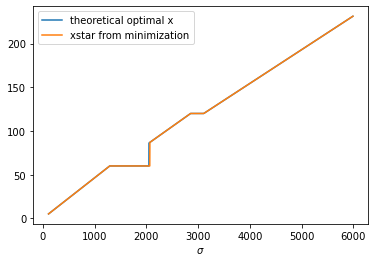

In [17]:
df_order = df.sort_values('sigma')
dfx_order = dfx.sort_values('sigma')
plt.plot(dfx_order.sigma, dfx_order.combined, label=r'theoretical optimal x')
plt.plot(df_order.sigma, df_order.xstar, label='xstar from minimization' )
#plt.xlim(100,800)
plt.xlabel(r'$\sigma$')
plt.legend()

plot the optimal $x(\sigma)$ and the functions $C(x,\sigma)$ and $K(x,\sigma)$

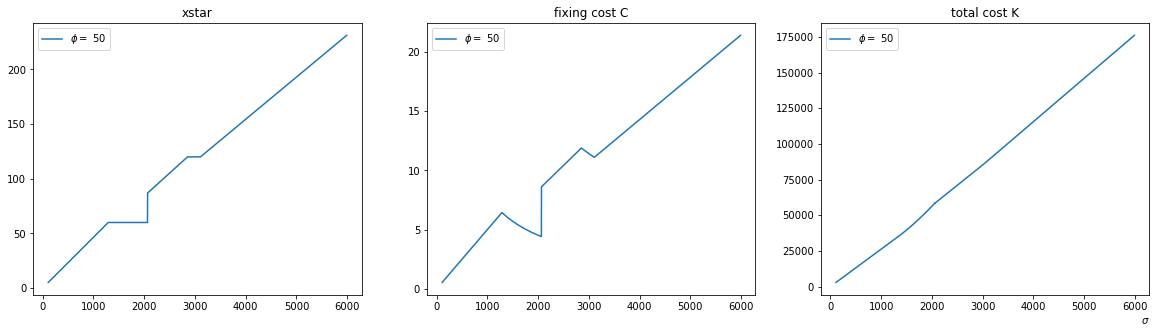

In [18]:
# first sort df in ascending order for sigmas
df_order = df.sort_values('sigma')

fig, axs = plt.subplots(1,3,figsize=(20,5), sharex=True)
axs[0].plot(df_order.sigma, df_order.xstar, label=f'$\phi =$ {phi}')
axs[0].set_title('xstar')
axs[1].plot(df_order.sigma, df_order.fixing_cost, label=f'$\phi =$ {phi}')
axs[1].set_title('fixing cost C')
axs[2].plot(df_order.sigma, df_order.K, label=f'$\phi =$ {phi}')
axs[2].set_title('total cost K')
axs[2].set_xlabel(r'$\sigma$', loc='right')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Indifference condition - Visualization  

{c: 799.698648092585}


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)
c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)


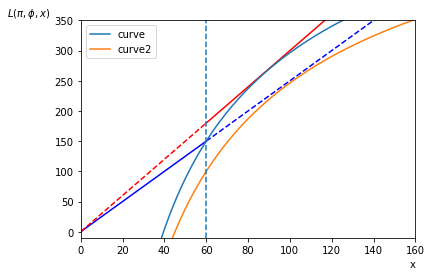

In [19]:
def curve(x, s,a, c=65):
    y = c-tools.C(x,sigma=s, alpha=a)
    return y

  
s = 185
a = .5

# I rescale it here because it would be very steep otherwise
slope1 = pi /100
slope2 = (pi + phi) /100

c=symbols('c')
exp = Eq(60*slope1 - curve(60, s=s, a=a,c=c),0)
res = solve([exp],(c))
print(res)

# lines
plt.plot([0,60],[0,60 * slope1], color = 'blue')
plt.plot([60,160],[60*slope1, 160*slope1], linestyle='dashed',color = 'blue')
plt.plot([0,60],[0,60 * slope2], linestyle='dashed',color = 'red')
plt.plot([60,160],[60*slope2, 160*slope2], color = 'red')
#curve
x = np.linspace(0,160,160)
y = [curve(x,s=s, a=a, c=res[c]) for x in x]
plt.plot(x,y, label='curve')
y2 = [curve(x,s=s, a=a, c=res[c]-50) for x in x]
plt.plot(x,y2, label='curve2')
plt.axvline(60, linestyle='dashed')
#plt.axvline(res[x], linestyle='dashed')
plt.xlim(0,160)
plt.ylim(-10,350)
plt.xlabel('x', loc='right')
plt.ylabel(r'$L(\pi, \phi, x)$', loc='top', rotation='horizontal')
plt.legend()
plt.show()

# Bunching Estimation

Since we're simulating the model, and there are no frictions such as optimization errors (we'll extend the model to include that later), all the bunching happens at $x^* = 60$, meaning that the bunching region is just a point. I changed the binsize to 1.    

We need to also calculate the missings mass and include it in the analysis. I added that to the code but if you could clean it up it would be great.

It would be great if you could plot the counterfactual density (i.e. plot the predicted values). 

The excess mass is the difference in height between the observed density and the counterfactual density. Say that number is 100. That says that there are 100 outages that are at 60 but would not have been there in the absence of the fine schedule. The task is to say from how far these outages are coming. This will depend on the counterfactual density and the height of the bins between $x^*=60$ and $x^*+\Delta x$ in the counterfactuals. In the below code we assume that these bins all have the same height in the counterfactual. However given our assumptions above (lognormal distribution) this is not the case (i.e. the sigmas are not uniformly distributed). It would be great if we could plot the density in the absense of the fine (e.g. plot the x's from minimizing K without the discontinuity) so we can compare the counterfactual density we are estimating to what the model says the counterfactual density should be. Hopefully this will help us decide how to distribute the excess mass correctly in order to estimate $\Delta x$ properly.



### Total Bunching

$B = \int_{x^*}^{x^* +\Delta x^*} h_{0}(x) dx$

In [28]:
# Bunching at x = 60
bsize = 2
missing60 = 60 + bsize*26

bunch60 = tools.bunching(data= df.xstar, bsize = bsize, xmax= 90, xmin= 10, z_upper= 60, z_lower= 59, missing = missing60, ex_reg= 1, poly_dgr=4)

display(bunch60.estimation_res())

print('deltaX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX())

pred60 = bunch60.prediction()

print('total bunching',bunch60.total_bunch(), 'truth',deltaX)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1327.
Date:                Thu, 09 Sep 2021   Prob (F-statistic):           8.20e-39
Time:                        14:09:34   Log-Likelihood:                -239.38
No. Observations:                  41   AIC:                             492.8
Df Residuals:                      34   BIC:                             504.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5046.9388    239.067    -21.111      0.000   -5532.781   -4561.096
duration     686.4495     27.719     24.764      0.000     630.117     742.782
duration2    -20.8989      1.058    -19.753      0.000     -23.049     -18.749
duration3      0.2427      0.016     15.036      0.000       0.210       0.276
duration4     -0.0010   8.32e-05    -11.688      0.000      -0.001      -0.001
b           5666.4152    104.684     54.129      0.000    5453.671    5879.159
m           -564.5387     94.606     -5.967      0.000    -756.801    -372.277
==============================================================================
Omnibus:                       10.218   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.216
Skew:                           0.489   Prob(JB):                     0.000111
Kurtosis:                       6.116   Cond. No.                     4.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

deltaX: 15.427531844473886 mX: -1.9604124548001143
total bunching 20.15567818235618 truth 35.3448064033245


In [21]:
# bunching at x = 120

missing120 = 120 + bsize*26

bunch120 = tools.bunching(data= df.xstar, bsize = 2, xmax= 200, xmin= 90, z_upper= 120, z_lower= 118, missing = missing120, ex_reg= 1, poly_dgr=4)

display(bunch120.estimation_res())

print('deltaX:', bunch120.get_deltaX())
print('total bunching:',bunch120.total_bunch(), 'truth:',deltaX120)

pred120 = bunch120.prediction()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     185.3
Date:                Thu, 09 Sep 2021   Prob (F-statistic):           6.56e-32
Time:                        13:58:00   Log-Likelihood:                -175.17
No. Observations:                  56   AIC:                             364.3
Df Residuals:                      49   BIC:                             378.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1666.7126    574.398      2.902      0.006     512.416    2821.009
duration     -36.4990     17.142     -2.129      0.038     -70.948      -2.050
duration2      0.2964      0.187      1.588      0.119      -0.079       0.671
duration3     -0.0011      0.001     -1.211      0.232      -0.003       0.001
duration4   1.423e-06    1.5e-06      0.946      0.349    -1.6e-06    4.45e-06
b             42.8266      6.415      6.676      0.000      29.936      55.718
m              6.2922      4.072      1.545      0.129      -1.891      14.475
==============================================================================
Omnibus:                       77.871   Durbin-Watson:                   2.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1163.505
Skew:                           3.687   Prob(JB):                    2.23e-253
Kurtosis:                      24.078   Cond. No.                     5.31e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

deltaX: 6.043231296111032
total bunching: 0.2585776874672032 truth: 10.7295905075578


### Plot the density of x and the counterfactual density given by the prediction

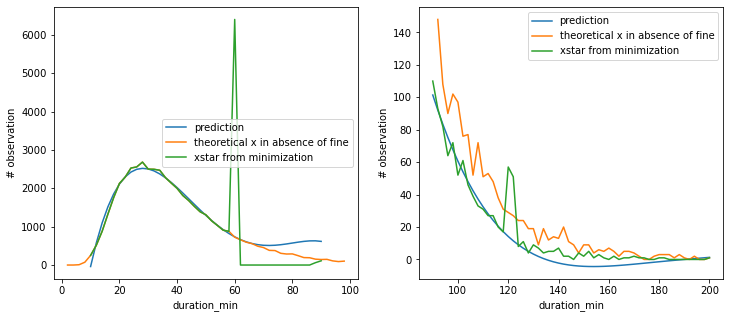

In [22]:
nbins = int(200/bsize +1)
bins = [(x) * bsize for x in range(nbins)]
nobs_wo_fine = dfx.xopts.groupby(pd.cut(dfx.xopts, bins)).count()
# put it in a df
nobs_wo_fine = pd.DataFrame(list(zip([(x,x+bsize) for x in bins],nobs_wo_fine)), columns=['bin', 'nobs'])
nobs_wo_fine['duration'] = nobs_wo_fine.apply(lambda row: row.bin[1], axis = 1)

dfs = {'60': pred60, '120':pred120}
fig, axes = plt.subplots(1,2, figsize=(12,5))
axs = {'60':axes[0], '120':axes[1]}
nobs_wofine = {'60': nobs_wo_fine.loc[nobs_wo_fine.duration < 100], '120': nobs_wo_fine.loc[nobs_wo_fine.duration > 90]}

for i in ['60', '120']:
    ax = axs[i]
    data = dfs[i]
    wofine = nobs_wofine[i]
    ax.plot(data.duration, data.y_pred, label = 'prediction')
    ax.plot(wofine.duration, wofine.nobs, label = 'theoretical x in absence of fine')
    ax.plot(data.duration, data.nobs, label = 'xstar from minimization')
    ax.legend()
    ax.set_xlabel('duration_min')
    ax.set_ylabel(r'# observation') 

solve for $\alpha$ :

$ (1 + \frac{\Delta x^*}{x^*}) [(\frac{\pi + \phi}{\phi})^{\alpha / (1+\alpha)} (\alpha +1) - (1 + \frac{\Delta x^*}{x^*})^{\alpha}] = \alpha * (\frac{\pi + \phi}{\phi}) $

In [30]:
## We need to use fsolve to solve this problem numerically.
a = symbols('a')
### Let's use the delta_x implied by our model (solving it from the value of sigma_bar above) as the bunching estimation is not working well at the moment.
delta_x = np.array(deltaX,dtype='float64')
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+phi)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=phi, phi120 = phi,alpha=a)             

def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)
res = fsolve(solution, 1)
print('alpha:', np.round(res[0],2))

alpha: 0.8


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  first = sigma / alpha


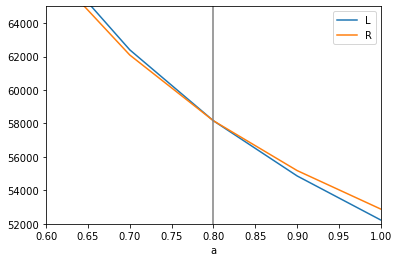

In [24]:
# plot 
a = np.arange(0,2.5,0.1)  

left = [L(a)  for a in a]
right = [R(a) for a in a]
tradeoff = pd.DataFrame({'a':a, 'left':left, 'right':right}).sort_values('a')
tradeoff
plt.plot(tradeoff.a, tradeoff.left, label =r'L')
plt.plot(tradeoff.a, tradeoff.right, label = r'R')
plt.axvline(res[0], color='grey')
plt.xlabel(r'a')
plt.ylim(52000,65000)
plt.xlim(0.6,1)
plt.legend()

## Compare the costs of actual x's and the prediction

$ K = (\pi + \phi) x (1 + 1/\alpha)$

In [25]:
'''
def get_cost(x, pi = pi, phi = 0, alpha = res[0]):
    return (pi + phi) * x * (1+ 1/alpha)

costs = count_reg[['duration_min', 'nobs', 'ypred']]


costs['K_nobs'] , costs['K_pred'] = 0, 0
costs.loc[costs.duration_min <= 60, 'K_nobs'] = costs.apply(lambda row: get_cost(row.nobs), axis = 1)
costs.loc[costs.duration_min <= 60, 'K_pred'] = costs.apply(lambda row: get_cost(row.ypred), axis = 1)
costs.loc[costs.duration_min <= 120, 'K_nobs'] = costs.apply(lambda row: get_cost(row.nobs, phi = phi), axis = 1)
costs.loc[costs.duration_min <= 120, 'K_pred'] = costs.apply(lambda row: get_cost(row.ypred, phi = phi), axis = 1)

print(np.sum(costs.K_nobs), np.sum(costs.K_pred))
print(np.sum(costs.K_nobs) > np.sum(costs.K_pred))
print(np.sum(costs.K_nobs) - np.sum(costs.K_pred))
'''


"\ndef get_cost(x, pi = pi, phi = 0, alpha = res[0]):\n    return (pi + phi) * x * (1+ 1/alpha)\n\ncosts = count_reg[['duration_min', 'nobs', 'ypred']]\n\n\ncosts['K_nobs'] , costs['K_pred'] = 0, 0\ncosts.loc[costs.duration_min <= 60, 'K_nobs'] = costs.apply(lambda row: get_cost(row.nobs), axis = 1)\ncosts.loc[costs.duration_min <= 60, 'K_pred'] = costs.apply(lambda row: get_cost(row.ypred), axis = 1)\ncosts.loc[costs.duration_min <= 120, 'K_nobs'] = costs.apply(lambda row: get_cost(row.nobs, phi = phi), axis = 1)\ncosts.loc[costs.duration_min <= 120, 'K_pred'] = costs.apply(lambda row: get_cost(row.ypred, phi = phi), axis = 1)\n\nprint(np.sum(costs.K_nobs), np.sum(costs.K_pred))\nprint(np.sum(costs.K_nobs) > np.sum(costs.K_pred))\nprint(np.sum(costs.K_nobs) - np.sum(costs.K_pred))\n"

## Get underlying distribution of $\sigma$ and x

idea: make use of the function xopt() to restore sigma using the xstar from minimization

extract the range from $x^*$ to $x^* + \Delta x^*$ and connect it with a line (or a polynomial), then find best distribution using fitter library

{'logistic': 2.087296777934663e-172, 'norm': 7.464851338280548e-182, 'lognorm': 1.0680603552677742e-236}
60 : distribution with best p-value of kstest:  lognorm 

{'logistic': 3.6194874036328082e-16, 'norm': 2.4568687015392897e-19, 'lognorm': 0.00743503424502804}
120 : distribution with best p-value of kstest:  norm 

{'60': (0.33421298574492675, -10.812221799983707, 45.13474598090477), '120': (107.34472271496631, 17.257407646465456)}


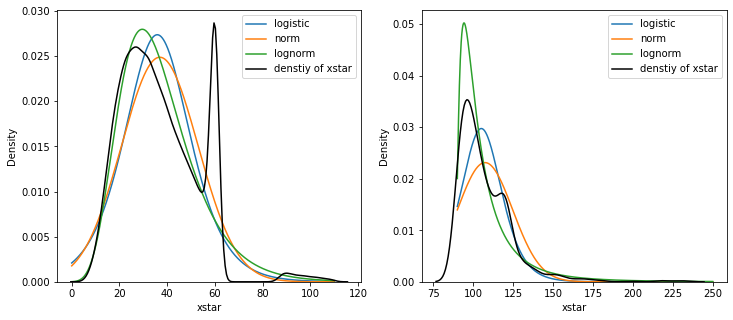

In [26]:
distributions = ['logistic', 'norm', 'lognorm']
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = {'60':axs[0], '120':axs[1]}
xs = {'60':df.xstar[df.xstar <= 110], '120':df.xstar[df.xstar > 90]}
tests = {'60':np.linspace(0,110, len(xs['60'])), '120':np.linspace(90,250, len(xs['120']))}
fitted = {}
for a in ['60', '120']:
  dists = {}
  test = tests[a]
  axes = ax[a]
  x = xs[a] 
  for d in distributions:
    dist = getattr(scipy.stats, d)
    params = dist.fit(x)
    pdf_fitted = dist.pdf(test, *params)
    axes.plot(test, pdf_fitted, label=d)
    p = scipy.stats.kstest(x, d, args=params)[1]
    dists[d] = p
  sns.kdeplot(x, label='denstiy of xstar', color = 'black', ax =axes)
  best = min(dists, key= dists.get)
  dist = getattr(scipy.stats, best)
  fitted[a] = dist.fit(x)
  print(dists)
  print(a, ': distribution with best p-value of kstest: ', best , '\n')
  axes.legend()

print(fitted)

In [27]:
'''
### testing poisson regression
coefs = ['duration_min']
[coefs.append('duration_min' + str(i)) for i in range(2,3)] 
coefs.append('b60')
coefs.append('m60')
X = count_reg.loc[:,coefs]

y = count_reg.loc[:,'nobs']
# regression
X = sm.add_constant(X)
poisson = sm.NegativeBinomial(y, X).fit()
display(poisson.summary())

X.b60=0
X.m60=0
y_pred = poisson.predict(X)

plt.plot(count_reg.duration_min, y_pred)
plt.plot(count_reg.duration_min, count_reg.nobs)
'''

"\n### testing poisson regression\ncoefs = ['duration_min']\n[coefs.append('duration_min' + str(i)) for i in range(2,3)] \ncoefs.append('b60')\ncoefs.append('m60')\nX = count_reg.loc[:,coefs]\n\ny = count_reg.loc[:,'nobs']\n# regression\nX = sm.add_constant(X)\npoisson = sm.NegativeBinomial(y, X).fit()\ndisplay(poisson.summary())\n\nX.b60=0\nX.m60=0\ny_pred = poisson.predict(X)\n\nplt.plot(count_reg.duration_min, y_pred)\nplt.plot(count_reg.duration_min, count_reg.nobs)\n"